<!--
---
title: "Linear Regression."
author: "Darya Vanichkina"
exercises: 30
keypoints: 
- Regression is the prediction of the value of a continuous variable based on one or more other continuous or categorical variables.
- Multiple types of regression can be implemented to fit the data
source: Rmd
start: 0
teaching: 30
bibliography: references.bib
---
-->

## Linear regression

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pickle 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

%matplotlib inline
sns.set(font_scale = 1.5)

In [2]:
def onehot_row_drop(df, column = 'column'):
    df = pd.concat([df.drop(column, axis=1), pd.get_dummies(df[column], drop_first=True, prefix=column)],axis=1)
    return(df)

def group_infrequent(df, columnname,counts = 10):
    df.loc[df[columnname].value_counts()[df[columnname]].values <= counts, columnname] = "Other"


def none_of_this_feature(df, column = 'column'):
    # adds a column to the dataframe with a value of 0 where there is none of this feature,
    # and a 1 where it's actually there
    df['No_' + column] = np.where(df[column]==0, 0, 1)
    return(df)

In [3]:
ameshousingClean = pd.read_csv('data/AmesHousingClean.csv')

# step 1
ameshousingClean['Age'] = ameshousingClean['Year_Sold'].max() - ameshousingClean['Year_Built']
ameshousingClean['Remodel_Age'] = ameshousingClean['Year_Sold'].max() - ameshousingClean['Year_Remod_Add']
ameshousingClean['Misc_Feature_Present'] =  np.where(ameshousingClean['Misc_Feature']=="None", 0, 1)


# step 2
# group situations where there are less than 20 cases of something
for i in ['Neighborhood', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd', 'Heating', 'MS_Zoning', 'Misc_Feature', 'Sale_Type']:
    group_infrequent(df=ameshousingClean, columnname=i, counts=20)


# Capture variables where some houses have "none of this feature" (i.e value of parameter = 0 aka zero-inflation)
none_of_feature = ['Second_Flr_SF','Three_season_porch','BsmtFin_SF_2','Bsmt_Unf_SF','Enclosed_Porch','Low_Qual_Fin_SF',
                   'Mas_Vnr_Area','Lot_Frontage','Open_Porch_SF','Screen_Porch','Pool_Area','Wood_Deck_SF', 'BsmtFin_SF_2', 'Second_Flr_SF']
for i in none_of_feature:
    ameshousingClean = none_of_this_feature(df = ameshousingClean, column=i)
    
# step 3
categorical_variable_list = ['Alley', 'Bldg_Type', 'Condition_1', 'Electrical', 'Exter_Cond', 'Exter_Qual', 
                             'Foundation', 'Functional', 'House_Style', 'Kitchen_Qual', 'Land_Contour', 
                             'Land_Slope', 'Lot_Config', 'Lot_Shape', 'Central_Air', 'Bsmt_Cond', 
                             'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Bsmt_Qual', 'Fence', 
                             'Fireplace_Qu', 'Garage_Cond', 'Garage_Finish', 'Garage_Type', 'Heating_QC',  
                              'MS_SubClass',  'Overall_Cond', 'Overall_Qual', 
                             'Paved_Drive', 'Roof_Style', 'Year_Sold', 'Neighborhood', 'Roof_Matl', 'Exterior_2nd',
                            'Exterior_1st', 'Heating', 'MS_Zoning', 'Misc_Feature', 'Street', 'Mas_Vnr_Type', 'Utilities',"Condition_2", "Pool_QC", "Garage_Qual", 'Sale_Type', 'Sale_Condition']

# step 4
# one hot encode the other categoricals
for i in categorical_variable_list:
    ameshousingClean = onehot_row_drop(df = ameshousingClean, column=i)

# step 5
# drop double no basement: (ranges from 80 to 83 in dataset, going with 80)
ameshousingClean = ameshousingClean.drop('Bsmt_Exposure_No_Basement', axis=1)
ameshousingClean = ameshousingClean.drop('BsmtFin_Type_2_No_Basement', axis=1)
ameshousingClean = ameshousingClean.drop('Bsmt_Qual_No_Basement', axis=1)
ameshousingClean = ameshousingClean.drop('Garage_Finish_No_Garage', axis=1)
ameshousingClean = ameshousingClean.drop('Garage_Type_No_Garage', axis=1)
ameshousingClean = ameshousingClean.drop('Garage_Qual_No_Garage', axis=1)
ameshousingClean = ameshousingClean.drop('Year_Built', axis=1)
ameshousingClean = ameshousingClean.drop('Year_Remod_Add', axis=1)

> ## Challenge 1
>
> Look at the code above. Can you explain why each of these transformations is being carried out? 
> See if you can figure out, in your groups, what each of the steps is doing.
> 
> {: .source}
>
> > ## Solution
> > 
> > {: .output}
> {: .solution}
{: .challenge}

Add a column to the dataset to split the Sale Price by percentile into 10 bins:

In [4]:
ameshousingClean['Sale_Price_quartile'] =  pd.qcut(ameshousingClean['Sale_Price'], 10, labels=range(10))

Now we can use scikit-learn's train-test split to split the data into a training and testing subset, stratifying it by the percentile bin of the Sale_Price:

In [5]:
index_train, index_test  = train_test_split(np.array(ameshousingClean.index), train_size=0.7, test_size = 0.3, 
                                            stratify = np.array(ameshousingClean['Sale_Price_quartile']), random_state=42)
ameshousingClean = ameshousingClean.drop('Sale_Price_quartile', axis = 1)

# Create variables for the training and test sets 
ames_train = ameshousingClean.loc[index_train,:].copy()
ames_test =  ameshousingClean.loc[index_test,:].copy()

In [6]:
# What are their dimensions?
print(ames_train.shape)
print(ames_test.shape)

(2051, 287)
(879, 287)


Get a list of predictor names and make numpy matrices of the data:

In [7]:
predictors = list(ameshousingClean.columns)
predictors.remove('Sale_Price')

# 
pickle.dump(predictors, open('models/predictors.pickle', 'wb'))

In [8]:
# Create training and test response vectors
ames_train_y = np.log10(ames_train['Sale_Price'])
ames_test_y = np.log10(ames_test['Sale_Price'])

# Write training and test design matrices
ames_train_X = ames_train[predictors].copy()
ames_test_X = ames_test[predictors].copy()


# save them to files as well (this is an extra step that's not necessary in class, but useful for our jupyter notebook class notes)
pickle.dump(ames_train_y, open('models/ames_train_y.pickle', 'wb'))
pickle.dump(ames_test_y, open('models/ames_test_y.pickle', 'wb'))
pickle.dump(ames_train_X, open('models/ames_train_X.pickle', 'wb'))
pickle.dump(ames_test_X, open('models/ames_test_X.pickle', 'wb'))

In [9]:
type(ames_train_X)

pandas.core.frame.DataFrame

In [10]:
type(ames_train_y)

pandas.core.series.Series

## Fit OLS models with different features

In [20]:
## Fit an Ordinary Least Squares Regression using all variables
ames_ols_all = LinearRegression()
ames_ols_all.fit(ames_train_X, ames_train_y)


## Fit an Ordinary Least Squares Regression using Gr_Liv_Area
ames_ols_GrLivArea = LinearRegression()
ames_ols_GrLivArea.fit(ames_train_X['Gr_Liv_Area'].values.reshape(-1, 1), ames_train_y)

## 
ames_ols_Second_Flr_SF = LinearRegression()
ames_ols_Second_Flr_SF.fit(ames_train_X['Second_Flr_SF'].values.reshape(-1, 1), ames_train_y)

## Fit an Ordinary Least Squares Regression using Gr_Liv_Area and Second_Flr_SF
ames_ols_GrLivArea_Second_Flr_SF = LinearRegression()
ames_ols_GrLivArea_Second_Flr_SF.fit(ames_train_X[['Gr_Liv_Area','Second_Flr_SF']], ames_train_y)

## Fit an Ordinary Least Squares Regression using Gr_Liv_Area and Age
ames_ols_GrLivArea_Age = LinearRegression()
ames_ols_GrLivArea_Age.fit(ames_train_X[['Gr_Liv_Area','Age']], ames_train_y)

/Users/darya/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/darya/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## Assess model fit

In [27]:
columns=['Test RMSE', 'Test R2', 'Test MAE']
rows=['All', 'GrLivArea','Second_Flr_SF', 'GrLivArea_Age', 'GrLivArea Second_Flr_SF']
results=pd.DataFrame(0.0, columns=columns, index=rows)




def assess_fit_vars(listOfMethods, variables, testX, testY):
    for i, method in enumerate(methods):
        if variables[i] != ":":
            tmp_test_X = testX[variables[i]]
            if type(variables[i]) == str: #only one column - so need to reshape
                tmp_test_X = testX[variables[i]].values.reshape(-1, 1)
        else:
            tmp_test_X=testX
        # while we build the model and predict on the log10Transformed sale price, we display the error in dollars
        # as that makes more sense
        y_pred=10**(method.predict(tmp_test_X))
        results.iloc[i,0] = np.sqrt(mean_squared_error(10**(testY), y_pred))
        results.iloc[i,1] = r2_score(10**(testY), y_pred)
        results.iloc[i,2] = mean_absolute_error(10**(testY), y_pred)
    return(results.round(3))

methods =[ames_ols_all,  ames_ols_GrLivArea, ames_ols_Second_Flr_SF, ames_ols_GrLivArea_Age, ames_ols_GrLivArea_Second_Flr_SF]

variables =[":", 'Gr_Liv_Area','Second_Flr_SF',['Gr_Liv_Area', 'Age'], ['Gr_Liv_Area', 'Second_Flr_SF']]

compare_train = assess_fit_vars(listOfMethods = methods,variables=variables, testX = ames_train_X, testY = ames_train_y)
compare_train.sort_values('Test RMSE')

,Test RMSE,Test R2,Test MAE
All,18810.886,0.946,11761.208
GrLivArea_Age,50897.025,0.603,29818.203
GrLivArea,64884.161,0.355,40056.146
Second_Flr_SF,78956.645,0.046,53158.416
GrLivArea Second_Flr_SF,79609.931,0.030,38615.494


In [ ]:
# on the test! set
compare = assess_fit_vars(listOfMethods = methods,variables=variables, testX = ames_test_X, testY = ames_test_y)
compare.sort_values('Test RMSE')

In [86]:
# lets explore the coefficients
print(ameshousingClean.columns.get_loc('Gr_Liv_Area'))
print(ameshousingClean.columns.get_loc('Age'))
print(ameshousingClean.columns.get_loc('Second_Flr_SF'))

10
32
8


> ## Challenge 2
>
> 1. Explore the coefficients for Gr_Liv_Area, Second_Flr_SF,  Gr_Liv_Area + Second_Flr_SF, 
> Gr_Liv_Area + Age, and the coefficients for these parameters for a model that 
> incorporates all of them. What do you observe? Are the coefficients for each parameter consistent among all the models?
>
> 2. Which model performs the best? Why? 
>
> 3. Does the same model perform best for the training and test data? Why?
>
>
>
> {: .source}
>
> > ## Solution
> > 
> > This is a discussion challenge. Answers will be discussed as a group. 
> > To get the coefficients for each model, use the `ames_ols_GrLivArea.coef_` method.
> >
> > 
> > 
> > {: .output}
> {: .solution}
{: .challenge}

In [87]:
# save OLS model to pickle
pickle.dump(ames_ols_all, open('models/ames_ols_all.pickle', 'wb'))

In [ ]:
# Import CSV mtcars
data = pd.read_csv('https://gist.githubusercontent.com/ZeccaLehn/4e06d2575eb9589dbe8c365d61cb056c/raw/64f1660f38ef523b2a1a13be77b002b98665cdfe/mtcars.csv')
# Edit element of column header
data.rename(columns={'Unnamed: 0':'brand'}, inplace=True)



ameshousingClean = ameshousingClean.drop('Sale_Price_quartile', axis = 1)

# Create variables for the training and test sets 
ames_train = ameshousingClean.loc[index_train,:].copy()
ames_test =  ameshousingClean.loc[index_test,:].copy()

In [11]:
data = pd.read_csv('https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/mpg.csv')
data.head()

sns.lmplot(
    data = data,
    x = 'cty', y = 'hwy', hue = 'drv'
)

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
0,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
1,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
2,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
3,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
4,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact


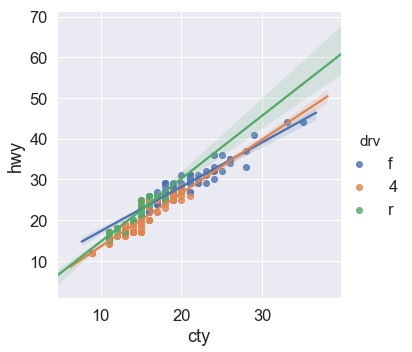